In [1]:
!pip install -q kaggle

In [2]:
!mkdir '../root/.kaggle/'
!touch '../root/.kaggle/kaggle.json'
!echo '{"username":"alvinkimata","key":"7781eeebf57aca5dd54a6c192a875d5f"}' >> '../root/.kaggle/kaggle.json'
!chmod 600 '../root/.kaggle/kaggle.json'
!cat '../root/.kaggle/kaggle.json'

{"username":"alvinkimata","key":"7781eeebf57aca5dd54a6c192a875d5f"}


In [3]:
#Download dataset from Kaggle.
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:20<00:00, 177MB/s]
100% 2.29G/2.29G [00:20<00:00, 120MB/s]


In [4]:
!unzip -q chest-xray-pneumonia.zip

In [5]:
import os
import copy
import random

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms, models, datasets

if torch.cuda.is_available():
    print('CUDA is available. Working on GPU')
    DEVICE = torch.device('cuda')
else:
    print('CUDA is not available. Working on CPU')
    DEVICE = torch.device('cpu')

CUDA is available. Working on GPU


In [6]:
SEED = 42 # "Answer to the Ultimate Question of Life, the Universe, and Everything"
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(SEED)

batch_size = 64

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

root_dir = '/content/chest_xray/'

train_dir = os.path.join(root_dir, 'train')
valid_dir = os.path.join(root_dir, 'val')
test_dir  = os.path.join(root_dir, 'test')

img_size = 224

cuda


In [7]:
# unused (actually used for plotting), better way found (marked as "* better way")
def  generate_dataframes(root_dir):
    train_df = pd.DataFrame(columns=['xray_dir', 'pneumonia (label)'])
    test_df  = pd.DataFrame(columns=['xray_dir', 'pneumonia (label)'])
    valid_df = pd.DataFrame(columns=['xray_dir', 'pneumonia (label)'])

    for dirname, _, filenames in os.walk(root_dir):

        # Train
        if dirname == root_dir + 'train/' + 'NORMAL':
            for filename in filenames:
                train_df.loc[len(train_df)] = [dirname + '/' + filename, 0]

        elif dirname == root_dir + 'train/' + 'PNEUMONIA':
            for filename in filenames:
                train_df.loc[len(train_df)] = [dirname + '/' + filename, 1]

        # Test
        if dirname == root_dir + 'test/' + 'NORMAL':
            for filename in filenames:
                test_df.loc[len(test_df)] = [dirname + '/' + filename, 0]

        elif dirname == root_dir + 'test/' + 'PNEUMONIA':
            for filename in filenames:
                test_df.loc[len(test_df)] = [dirname + '/' + filename, 1]

        # Validation
        if dirname == root_dir + 'val/' + 'NORMAL':
            for filename in filenames:
                valid_df.loc[len(valid_df)] = [dirname + '/' + filename, 0]

        elif dirname == root_dir + 'val/' + 'PNEUMONIA':
            for filename in filenames:
                valid_df.loc[len(valid_df)] = [dirname + '/' + filename, 1]

    return train_df, test_df, valid_df

train_df, test_df, valid_df = generate_dataframes(root_dir)

In [8]:
train_df.head(2)

,xray_dir,pneumonia (label)
0,/content/chest_xray/train/PNEUMONIA/person1597...,1
1,/content/chest_xray/train/PNEUMONIA/person23_b...,1


In [9]:
counts = train_df['pneumonia (label)'].value_counts()
counts

1    3875
0    1341
Name: pneumonia (label), dtype: int64

Text(0.5, 1.0, 'Pneumonia x Normal')

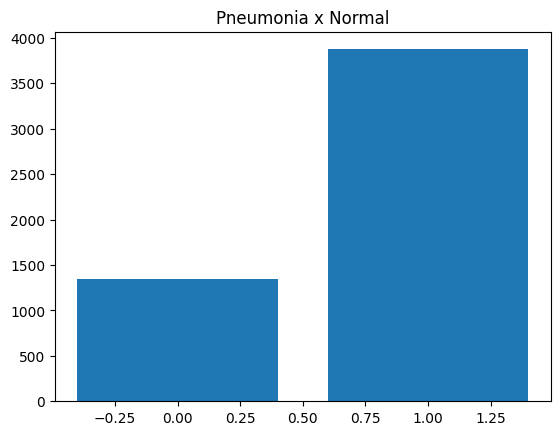

In [10]:
plt.bar(counts.index, counts)
plt.title('Pneumonia x Normal')

In [11]:
class Dataset(Dataset):
    def __init__(self, data, target, transform=None, device=device):
        self.device = device
        self.data = data
        self.target = target
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index].to(self.device)
        y = self.target[index].to(self.device)

        #if (y == 0) and self.transform: # check for minority class
        x = self.transform(x)

        return x, y

# num_classes = 2
def unbalanced_dataset_weights(instances):
    count = [0] * 2
    for item in instances:
        count[item[1]] += 1

    class_weight = [0.] * 2
    total = float(sum(count))

    for i in range(2):
        class_weight[i] = total/float(count[i])

    weight = [0] * len(instances)

    for index, value in enumerate(instances):
        weight[index] = class_weight[value[1]]

    return weight


transform = transforms.Compose([transforms.Resize((img_size, img_size)),
                                transforms.RandomRotation(30),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.ToTensor()])

train_ds = datasets.ImageFolder(train_dir, transform)
weights = unbalanced_dataset_weights(train_ds.imgs)
weights = torch.tensor(weights, dtype=torch.double)
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))
train_dataloader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, sampler= sampler)

valid_ds = datasets.ImageFolder(valid_dir, transform)
valid_dataloader = torch.utils.data.DataLoader(valid_ds, batch_size=2, shuffle=False)

test_ds = datasets.ImageFolder(test_dir, transform)
test_dataloader = torch.utils.data.DataLoader(test_ds, batch_size=1, shuffle=False)

In [12]:
import sys

def training(model, model_name, num_epochs, train_dataloader, val_dataloader):

    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.33)

    train_loss_array = []
    train_acc_array = []
    val_loss_array = []
    val_acc_array = []
    lowest_val_loss = np.inf
    best_model = None

    for epoch in range(num_epochs):

        print('Epoch: {} | Learning rate: {}'.format(epoch + 1, scheduler.get_lr()))

        for phase in ['train', 'val']:

            epoch_loss = 0
            epoch_correct_items = 0
            epoch_items = 0

            if phase == 'train':
                model.train()
                with torch.enable_grad():
                    for samples, targets in tqdm(train_dataloader):
                        samples = samples.to(DEVICE)
                        targets = targets.to(DEVICE)

                        optimizer.zero_grad()
                        outputs = model(samples)
                        loss = loss_function(outputs, targets)
                        preds = outputs.argmax(dim=1)
                        correct_items = (preds == targets).float().sum()

                        loss.backward()
                        optimizer.step()

                        epoch_loss += loss.item()
                        epoch_correct_items += correct_items.item()
                        epoch_items += len(targets)
                print(epoch_items)

                train_loss_array.append(epoch_loss / epoch_items)
                train_acc_array.append(epoch_correct_items / epoch_items)

                scheduler.step()

            elif phase == 'val':
                model.eval()
                with torch.no_grad():
                    for samples, targets in tqdm(val_dataloader, file=sys.stdout):
                        samples = samples.to(DEVICE)
                        targets = targets.to(DEVICE)

                        outputs = model(samples)
                        loss = loss_function(outputs, targets)
                        preds = outputs.argmax(dim=1)
                        correct_items = (preds == targets).float().sum()

                        epoch_loss += loss.item()
                        epoch_correct_items += correct_items.item()
                        epoch_items += len(targets)
                print(epoch_items)

                val_loss_array.append(epoch_loss / epoch_items)
                val_acc_array.append(epoch_correct_items / epoch_items)

                if epoch_loss / epoch_items < lowest_val_loss:
                    lowest_val_loss = epoch_loss / epoch_items
                    torch.save(model.state_dict(), '{}_weights.pth'.format(model_name))
                    best_model = copy.deepcopy(model)
                    print("\t| New lowest val loss for {}: {}".format(model_name, lowest_val_loss))

    return best_model, train_loss_array, train_acc_array, val_loss_array, val_acc_array

In [13]:
def visualize_training_results(train_loss_array,
                               val_loss_array,
                               train_acc_array,
                               val_acc_array,
                               num_epochs,
                               model_name,
                               batch_size):
    fig, axs = plt.subplots(1, 2, figsize=(14,4))
    fig.suptitle("{} training | Batch size: {}".format(model_name, batch_size), fontsize = 16)
    axs[0].plot(list(range(1, num_epochs+1)), train_loss_array, label="train_loss")
    axs[0].plot(list(range(1, num_epochs+1)), val_loss_array, label="val_loss")
    axs[0].legend(loc='best')
    axs[0].set(xlabel='epochs', ylabel='loss')
    axs[1].plot(list(range(1, num_epochs+1)), train_acc_array, label="train_acc")
    axs[1].plot(list(range(1, num_epochs+1)), val_acc_array, label="val_acc")
    axs[1].legend(loc='best')
    axs[1].set(xlabel='epochs', ylabel='accuracy')
    plt.show();

## Train Densenet

In [ ]:
num_epochs = 2

model_densenet161 = models.densenet161(pretrained=True)
for param in model_densenet161.parameters():
    param.requires_grad = False
model_densenet161.classifier = torch.nn.Linear(model_densenet161.classifier.in_features, out_features=2)
model_densenet161 = model_densenet161.to(DEVICE)

densenet161_training_results = training(model=model_densenet161,
                                        model_name='DenseNet161',
                                        num_epochs=num_epochs,
                                        train_dataloader=train_dataloader,
                                        val_dataloader=test_dataloader)

model_densenet161, train_loss_array, train_acc_array, val_loss_array, val_acc_array = densenet161_training_results

min_loss = min(val_loss_array)
min_loss_epoch = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_epoch]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs,
                           model_name="DenseNet161",
                           batch_size=64)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during epoch #{}".format(min_loss, min_loss_epoch + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:00<00:00, 139MB/s] 
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings

Epoch: 1 | Learning rate: [0.0003]


 79%|███████▉  | 65/82 [02:06<00:36,  2.12s/it]

## Resnet 152

In [ ]:
model_resnet152 = models.resnet152(pretrained=True)
for param in model_resnet152.parameters():
    param.requires_grad = False
model_resnet152.fc = torch.nn.Linear(model_resnet152.fc.in_features, 2)
model_resnet152 = model_resnet152.to(DEVICE)

resnet152_training_results = training(model=model_resnet152,
                                      model_name='ResNet152',
                                      num_epochs=num_epochs,
                                      train_dataloader=train_dataloader,
                                      val_dataloader=valid_dataloader)

model_resnet152, train_loss_array, train_acc_array, val_loss_array, val_acc_array = resnet152_training_results

min_loss = min(val_loss_array)
min_loss_epoch = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_epoch]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs,
                           model_name="ResNet152",
                           batch_size=64)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during epoch #{}".format(min_loss, min_loss_epoch + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

## VGG19

In [ ]:
model_vgg19_bn = models.vgg19_bn(pretrained=True)
for param in model_vgg19_bn.parameters():
    param.requires_grad = False
model_vgg19_bn.classifier[6] = torch.nn.Linear(in_features=model_vgg19_bn.classifier[6].in_features, out_features=2)
model_vgg19_bn = model_vgg19_bn.to(DEVICE)

vgg19_bn_training_results = training(model=model_vgg19_bn,
                                     model_name='VGG19_bn',
                                     num_epochs=num_epochs,
                                     train_dataloader=train_dataloader,
                                     val_dataloader=valid_dataloader)

model_vgg19_bn, train_loss_array, train_acc_array, val_loss_array, val_acc_array = vgg19_bn_training_results

min_loss = min(val_loss_array)
min_loss_epoch = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_epoch]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs,
                           model_name="VGG19_bn",
                           batch_size=64)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during epoch #{}".format(min_loss, min_loss_epoch + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

## Training ensemble.

In [ ]:
class EnsembleModel(nn.Module):
    def __init__(self, modelA, modelB, modelC):
        super().__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.modelC = modelC
        self.classifier = nn.Linear(2 * 3, 2)

    def forward(self, x):
        x1 = self.modelA(x)
        x2 = self.modelB(x)
        x3 = self.modelC(x)
        x = torch.cat((x1, x2, x3), dim=1)
        out = self.classifier(x)
        return out

ensemble_model = EnsembleModel(model_densenet161, model_resnet152, model_vgg19_bn)

for param in ensemble_model.parameters():
    param.requires_grad = False

for param in ensemble_model.classifier.parameters():
    param.requires_grad = True

ensemble_model = ensemble_model.to(DEVICE)

In [ ]:
ensemble_training_results = training(model=ensemble_model,
                                     model_name='Ensemble',
                                     num_epochs=50,
                                     train_dataloader=train_dataloader,
                                     val_dataloader=valid_dataloader)

ensemble_model, train_loss_array, train_acc_array, val_loss_array, val_acc_array = ensemble_training_results

min_loss = min(val_loss_array)
min_loss_iteration = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_iteration]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs=50,
                           model_name="Ensemble model",
                           batch_size=64)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during iteration #{}".format(min_loss, min_loss_iteration + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))